# Grab Repository data      

In [1]:
from dotenv import load_dotenv
from helper.general import split_by_date, generate_value_in_buckets, truncate_to_same_length, aggregate_by_date, get_repository_paths
from helper.significance import check_normality_of_buckets, use_normality_results_for_significance_independent
import logging
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt

load_dotenv(override=True)

True

In [2]:
REPO_PATHS = os.getenv('STORAGE_DIRECTORIES')
repository_directories = ast.literal_eval(REPO_PATHS) if REPO_PATHS else []
INTRO_DATE = os.getenv('INTRO_DATE')
START_DATE = os.getenv('START_DATE')
END_DATE = os.getenv('END_DATE')
BUCKET_SIZE = int(os.getenv('BUCKET_SIZE'))
RESULTS_DIRECTORY = os.getenv("RESULTS_DIRECTORY")

storage_path = f'{RESULTS_DIRECTORY}/metric_calculation_{BUCKET_SIZE}/M2_per_{BUCKET_SIZE}_days.csv'

# Get only first-level subfolders in the repository directories
repositories = get_repository_paths(repository_directories)

print(repositories)

['/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P3', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P9', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P2', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P8', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P1', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/k1bu0cscd4', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/5x4imrvk5b', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P7', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P5', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P14', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P6', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/bznd2hh7ii', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person

In [3]:
if INTRO_DATE == "":
    import json
    mapping_file = f"{repository_directories[0]}/mapping.json"
    # Check if the file exists
    if not os.path.exists(mapping_file):
        print(f"File not found: {mapping_file}. ")
    with open(mapping_file, 'r') as f:
        mapping = json.load(f)
    print(f"Using INTRO_DATE from mapping file: {INTRO_DATE}")


Using INTRO_DATE from mapping file: 


# Generate File Level Code Churn per Repository

## Amount of changes per file per commit

In [4]:
results = []
import numpy as np
for repository in repositories:
    person = repository.split('/')[-1]
    if INTRO_DATE == "":
        INTRO_DATE = mapping[person]['INTRO_DATE']
        START_DATE = mapping[person]['START_DATE']
        END_DATE = mapping[person]['END_DATE']
    file_level_information = f'{repository}/commits_file_level_changes.csv'
    # Check if the file exists
    if not os.path.exists(file_level_information):
        print(f"File not found: {file_level_information}. Skipping repository.")
        continue

    aggregation_column = 'M2_relative_deleted_LOC_manually_parsed'
    
    file_level_df = pd.read_csv(file_level_information)

    # file_level_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # file_level_df['loc_changed'] = file_level_df['loc_added'] + file_level_df['loc_deleted']

    file_level_df = truncate_to_same_length(file_level_df, INTRO_DATE, 'date', 'defined', START_DATE, END_DATE)
    # file_level_df = aggregate_by_date(file_level_df, 'date', aggregation_column, 'sum')
    if len(file_level_df.columns)<4:
        continue
    
    pre_release, post_release = split_by_date(file_level_df, INTRO_DATE, 'date')
    # print(file_level_df.columns)
    pre_release_buckets = generate_value_in_buckets(pre_release, 'date', aggregation_column, 'mean', BUCKET_SIZE, 'pre-')
    post_release_buckets = generate_value_in_buckets(post_release, 'date', aggregation_column, 'mean', BUCKET_SIZE, 'post-')

    release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)

    repo_name = repository.split('/')[-1]
    
    result_row = {'repository': repo_name}
    result_row.update(release_buckets.set_index('bucket')[aggregation_column].to_dict())  # Use 'count' instead of 'value'
    
    results.append(result_row)

# Create the DataFrame
file_level_result_df = pd.DataFrame(results)
print(repository_directories)
    
file_level_result_df

File not found: /Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants/commits_file_level_changes.csv. Skipping repository.
['/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person']


/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_66098/615807285.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)


,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,post-0,post-1,post-2,post-3,post-4,post-5,post-6,post-7,post-8
0,P3,0.002102,0.024038,0.005468,0.146588,0.113642,0.032852,0.004684,0.003344,0.002814,0.004775,0.019398,0.044442,0.003860,0.005040,NaN,0.013845,0.010742,0.012481
1,P9,0.008323,0.014153,0.008804,0.000873,0.011991,0.024908,0.016737,0.000000,0.006282,0.020478,0.008406,0.016126,0.001566,0.000000,NaN,0.001040,0.051805,0.000369
2,P2,0.003759,0.000000,0.202400,0.018623,0.020175,0.006492,NaN,0.000000,NaN,0.009278,0.023493,0.003474,0.016377,0.000716,0.008065,0.000253,0.001048,0.002510
3,P8,0.024759,0.009198,0.036670,0.004693,0.019829,0.002568,0.071274,0.025557,0.015136,0.025677,0.164390,0.002870,0.016495,0.015583,0.042962,0.117810,0.032175,0.007050
4,P1,0.013097,0.014441,0.012920,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
5,k1bu0cscd4,0.000000,NaN,0.039700,NaN,0.011410,0.002020,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5x4imrvk5b,0.005012,0.007224,0.007143,0.005061,0.012575,0.005878,0.013014,0.078457,0.073235,0.029630,0.021635,0.020797,0.009251,0.000000,0.003989,0.020696,0.017524,0.003151
7,P7,0.001483,0.008612,0.000195,0.004190,0.035643,0.000000,0.005684,0.016131,NaN,0.000000,0.015207,0.004229,0.000000,0.003190,0.000000,0.003247,0.072236,0.052200
8,P5,0.013500,0.003530,0.008075,NaN,0.009752,0.020920,NaN,NaN,NaN,0.023467,0.006442,0.007500,0.002590,0.000631,NaN,0.012570,0.015099,0.020470
9,P14,0.010960,0.002301,0.008043,0.062585,0.024399,0.042607,0.011402,0.015044,0.001623,0.003867,0.007265,0.043097,0.011918,0.010699,0.000000,0.062928,0.014383,0.001357


In [5]:
# Ensure the columns are in the correct order
def sort_buckets(df, prefix_one, prefix_two):
    order = ['repository']
    
    for prefix in [prefix_one, prefix_two]:
        counter = 0
        contained = True
        
        while contained:
            order.append(f'{prefix}{counter}')
            
            counter += 1
            if not f'{prefix}{counter}' in df:
                contained = False
        
    return order

columns_order = sort_buckets(file_level_result_df, 'pre-', 'post-')
file_level_result_df = file_level_result_df[columns_order]

In [6]:
file_level_result_df

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,post-0,post-1,post-2,post-3,post-4,post-5,post-6,post-7,post-8
0,P3,0.002102,0.024038,0.005468,0.146588,0.113642,0.032852,0.004684,0.003344,0.002814,0.004775,0.019398,0.044442,0.003860,0.005040,NaN,0.013845,0.010742,0.012481
1,P9,0.008323,0.014153,0.008804,0.000873,0.011991,0.024908,0.016737,0.000000,0.006282,0.020478,0.008406,0.016126,0.001566,0.000000,NaN,0.001040,0.051805,0.000369
2,P2,0.003759,0.000000,0.202400,0.018623,0.020175,0.006492,NaN,0.000000,NaN,0.009278,0.023493,0.003474,0.016377,0.000716,0.008065,0.000253,0.001048,0.002510
3,P8,0.024759,0.009198,0.036670,0.004693,0.019829,0.002568,0.071274,0.025557,0.015136,0.025677,0.164390,0.002870,0.016495,0.015583,0.042962,0.117810,0.032175,0.007050
4,P1,0.013097,0.014441,0.012920,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
5,k1bu0cscd4,0.000000,NaN,0.039700,NaN,0.011410,0.002020,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5x4imrvk5b,0.005012,0.007224,0.007143,0.005061,0.012575,0.005878,0.013014,0.078457,0.073235,0.029630,0.021635,0.020797,0.009251,0.000000,0.003989,0.020696,0.017524,0.003151
7,P7,0.001483,0.008612,0.000195,0.004190,0.035643,0.000000,0.005684,0.016131,NaN,0.000000,0.015207,0.004229,0.000000,0.003190,0.000000,0.003247,0.072236,0.052200
8,P5,0.013500,0.003530,0.008075,NaN,0.009752,0.020920,NaN,NaN,NaN,0.023467,0.006442,0.007500,0.002590,0.000631,NaN,0.012570,0.015099,0.020470
9,P14,0.010960,0.002301,0.008043,0.062585,0.024399,0.042607,0.011402,0.015044,0.001623,0.003867,0.007265,0.043097,0.011918,0.010699,0.000000,0.062928,0.014383,0.001357


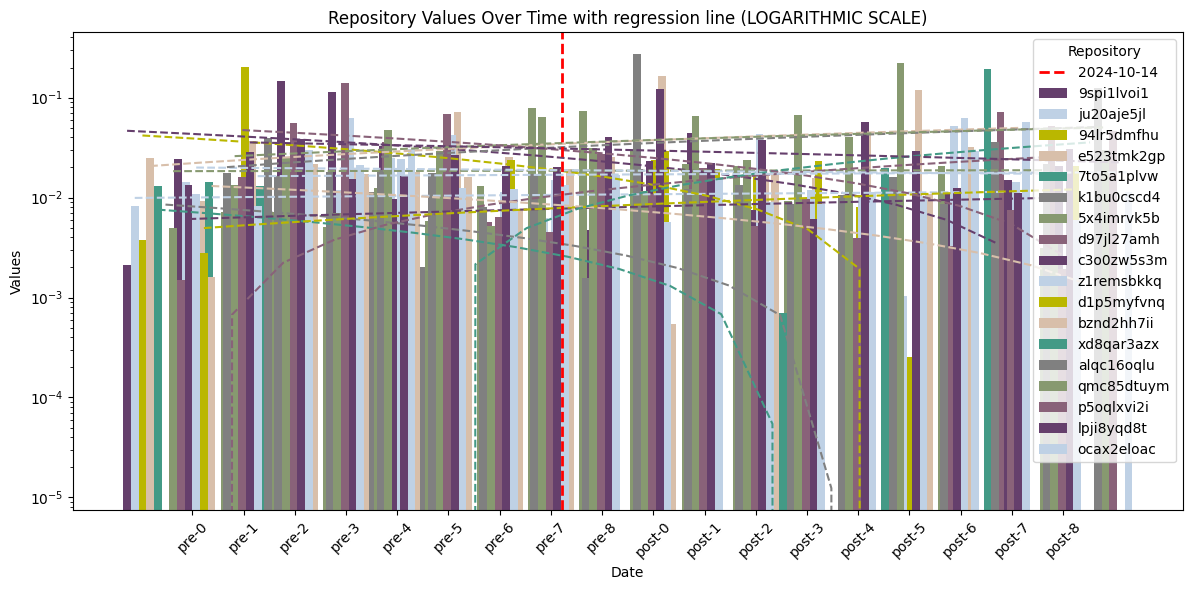

In [7]:
import numpy as np
from scipy.stats import linregress

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in file_level_result_df.columns if col != 'repository']
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#D8BFAA", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(file_level_result_df['repository']):
    # Extract data for the current repository
    values = file_level_result_df[file_level_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    slope, intercept, _, _, _ = linregress(x, values.values)
    regression_line = slope * x + intercept
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='--', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = file_level_result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))  # Find the largest 'pre-x'
    post_0 = 'post-0' if 'post-0' in post_columns else None  # Ensure 'post-0' exists

    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2
        plt.axvline(x=midpoint, color='red', linestyle='--', linewidth=2, label=INTRO_DATE)

# Set x-axis ticks and labels
plt.xticks(x + (len(file_level_result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
plt.yscale('log')
plt.show()

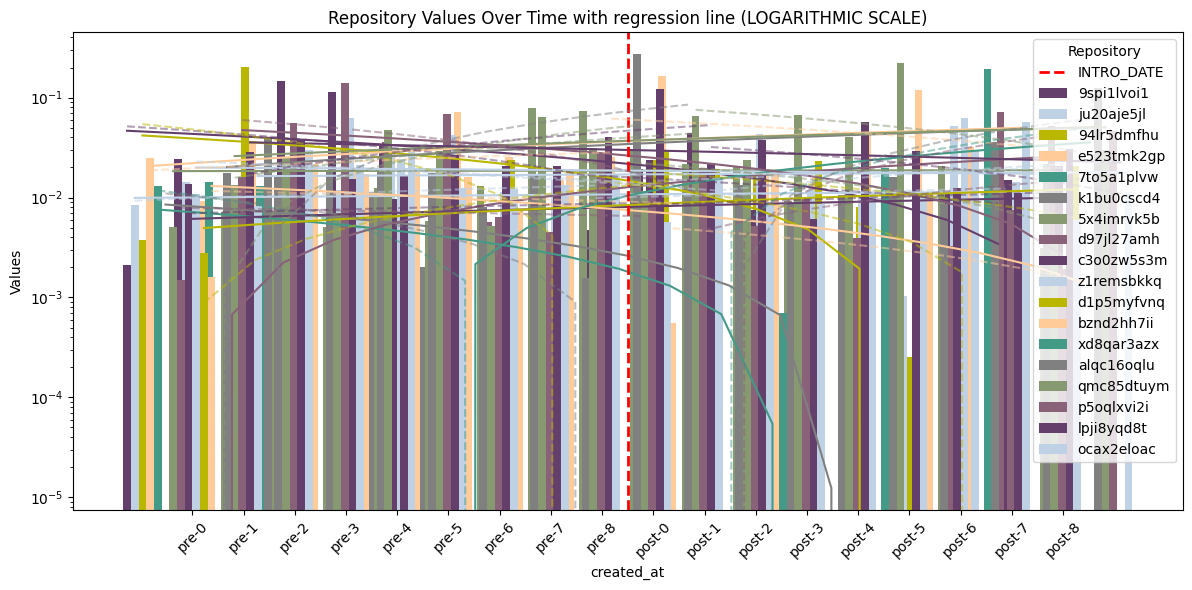

In [8]:
import numpy as np
from scipy.stats import linregress

tangent_data = []

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in file_level_result_df.columns if col != 'repository']
colors = ["#FF4500", "#FFA500", "#FF8C00", "#FFD700", "#FF6347", "#FF7F50", "#FFB347", "#FFCC99"]
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#FFCC99", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(file_level_result_df['repository']):
    # Extract data for the current repository
    values = file_level_result_df[file_level_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    m, b, _, _, _ = linregress(x, values.values)
    regression_line = m * x + b
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='-', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = file_level_result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))
    post_0 = 'post-0' if 'post-0' in post_columns else None
    
    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2

        # Vertical red line at midpoint
        plt.axvline(x=midpoint + (len(file_level_result_df['repository']) - 1) * bar_width / 2,
                    color='red', linestyle='--', linewidth=2, label="INTRO_DATE")

# Plot bars and regression lines
for i, repo in enumerate(file_level_result_df['repository']):
    values = file_level_result_df[file_level_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)

    offset_x = x + i * bar_width
    plt.bar(offset_x, values.values, bar_width, label="_nolegend_", color=colors[i % len(colors)])

    if pre_columns and post_columns and largest_pre and post_0:
        # Indices for regression segments
        pre_range = np.arange(0, post_0_index + 1)
        post_range = np.arange(post_0_index, len(values))

        # Extract values
        pre_values = values.values[pre_range]
        post_values = values.values[post_range]

        # Regression before midpoint
        m_pre, b_pre, *_ = linregress(pre_range, pre_values)
        reg_line_pre = m_pre * pre_range + b_pre
        plt.plot(offset_x[pre_range], reg_line_pre, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Regression after midpoint
        m_post, b_post, *_ = linregress(post_range, post_values)
        reg_line_post = m_post * post_range + b_post
        plt.plot(offset_x[post_range], reg_line_post, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Collect regression parameters
        tangent_data.append({
            'repository': repo,
            'm_pre': m_pre,
            'b_pre': b_pre,
            'm_post': m_post,
            'b_post': b_post
        })




# Set x-axis ticks and labels
plt.xticks(x + (len(file_level_result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('created_at')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
plt.yscale('log')
plt.show()

# Significancetest 

In [9]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Replace NaN values with 0 in the file_level_result_df
file_level_result_df = file_level_result_df.fillna(0)

# Columns for pre and after buckets
pre_columns = [col for col in file_level_result_df.columns if col.startswith("pre-")]
after_columns = [col for col in file_level_result_df.columns if col.startswith("post-")]

normality_results = check_normality_of_buckets(file_level_result_df, pre_columns, after_columns)

# Display the results
print(normality_results)

    repository  pre_p_value  after_p_value  pre_normal  after_normal
0   P3     0.001454       0.020891       False         False
1   P9     0.827996       0.002410        True         False
2   P2     0.000004       0.063198       False          True
3   P8     0.081158       0.007563        True         False
4   P1     0.000296       1.000000       False          True
5   k1bu0cscd4     0.000019       1.000000       False          True
6   5x4imrvk5b     0.000186       0.400629       False          True
7   P7     0.004067       0.000984       False         False
8   P5     0.059857       0.469391        True          True
9   P14     0.048811       0.009213       False         False
10  P6     0.001722       0.151266       False          True
11  bznd2hh7ii     0.056043       0.000065        True         False
12  xd8qar3azx     1.000000       0.000001        True         False
13  P4     0.000002       0.000048       False         False
14  P13     0.331578       0.002148        T

/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [10]:
# significance_results_df = use_normality_results_for_significance_independent(normality_results, file_level_result_df, pre_columns, after_columns)

# # Display the results
# print(significance_results_df)

from helper.significance import calculate_cliffs_delta_with_confidence
significance_results_df = calculate_cliffs_delta_with_confidence(file_level_result_df, pre_columns, after_columns)

# Display the results
print(significance_results_df)

    repository      test_used  effect_size  ci_lower  ci_upper
0   P3  Cliff's Delta    -0.061728 -0.605556  0.531481
1   P9  Cliff's Delta    -0.160494 -0.728395  0.382716
2   P2  Cliff's Delta     0.135802 -0.457407  0.703704
3   P8  Cliff's Delta     0.259259 -0.308642  0.753704
4   P1  Cliff's Delta    -0.333333 -0.666667  0.000000
5   k1bu0cscd4  Cliff's Delta    -0.333333 -0.666667 -0.111111
6   5x4imrvk5b  Cliff's Delta    -0.012346 -0.555556  0.629630
7   P7  Cliff's Delta     0.012346 -0.530864  0.518519
8   P5  Cliff's Delta     0.283951 -0.283951  0.777778
9   P14  Cliff's Delta    -0.160494 -0.703704  0.407407
10  P6  Cliff's Delta     0.234568 -0.308642  0.765432
11  bznd2hh7ii  Cliff's Delta    -0.580247 -0.926543 -0.160494
12  xd8qar3azx  Cliff's Delta     0.333333  0.000000  0.666667
13  P4  Cliff's Delta    -0.111111 -0.703704  0.481481
14  P13  Cliff's Delta     0.086420 -0.481481  0.630247
15  P12  Cliff's Delta    -0.456790 -0.901235  0.061728
16  P10  Cliff's Delta

In [11]:
merged = file_level_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-3,post-4,post-5,post-6,post-7,post-8,test_used,effect_size,ci_lower,ci_upper
0,P3,0.002102,0.024038,0.005468,0.146588,0.113642,0.032852,0.004684,0.003344,0.002814,...,0.003860,0.005040,0.000000,0.013845,0.010742,0.012481,Cliff's Delta,-0.061728,-0.605556,0.531481
1,P9,0.008323,0.014153,0.008804,0.000873,0.011991,0.024908,0.016737,0.000000,0.006282,...,0.001566,0.000000,0.000000,0.001040,0.051805,0.000369,Cliff's Delta,-0.160494,-0.728395,0.382716
2,P2,0.003759,0.000000,0.202400,0.018623,0.020175,0.006492,0.000000,0.000000,0.000000,...,0.016377,0.000716,0.008065,0.000253,0.001048,0.002510,Cliff's Delta,0.135802,-0.457407,0.703704
3,P8,0.024759,0.009198,0.036670,0.004693,0.019829,0.002568,0.071274,0.025557,0.015136,...,0.016495,0.015583,0.042962,0.117810,0.032175,0.007050,Cliff's Delta,0.259259,-0.308642,0.753704
4,P1,0.013097,0.014441,0.012920,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Cliff's Delta,-0.333333,-0.666667,0.000000
5,k1bu0cscd4,0.000000,0.000000,0.039700,0.000000,0.011410,0.002020,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Cliff's Delta,-0.333333,-0.666667,-0.111111
6,5x4imrvk5b,0.005012,0.007224,0.007143,0.005061,0.012575,0.005878,0.013014,0.078457,0.073235,...,0.009251,0.000000,0.003989,0.020696,0.017524,0.003151,Cliff's Delta,-0.012346,-0.555556,0.629630
7,P7,0.001483,0.008612,0.000195,0.004190,0.035643,0.000000,0.005684,0.016131,0.000000,...,0.000000,0.003190,0.000000,0.003247,0.072236,0.052200,Cliff's Delta,0.012346,-0.530864,0.518519
8,P5,0.013500,0.003530,0.008075,0.000000,0.009752,0.020920,0.000000,0.000000,0.000000,...,0.002590,0.000631,0.000000,0.012570,0.015099,0.020470,Cliff's Delta,0.283951,-0.283951,0.777778
9,P14,0.010960,0.002301,0.008043,0.062585,0.024399,0.042607,0.011402,0.015044,0.001623,...,0.011918,0.010699,0.000000,0.062928,0.014383,0.001357,Cliff's Delta,-0.160494,-0.703704,0.407407


In [12]:
merged = file_level_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-3,post-4,post-5,post-6,post-7,post-8,test_used,effect_size,ci_lower,ci_upper
0,P3,0.002102,0.024038,0.005468,0.146588,0.113642,0.032852,0.004684,0.003344,0.002814,...,0.003860,0.005040,0.000000,0.013845,0.010742,0.012481,Cliff's Delta,-0.061728,-0.605556,0.531481
1,P9,0.008323,0.014153,0.008804,0.000873,0.011991,0.024908,0.016737,0.000000,0.006282,...,0.001566,0.000000,0.000000,0.001040,0.051805,0.000369,Cliff's Delta,-0.160494,-0.728395,0.382716
2,P2,0.003759,0.000000,0.202400,0.018623,0.020175,0.006492,0.000000,0.000000,0.000000,...,0.016377,0.000716,0.008065,0.000253,0.001048,0.002510,Cliff's Delta,0.135802,-0.457407,0.703704
3,P8,0.024759,0.009198,0.036670,0.004693,0.019829,0.002568,0.071274,0.025557,0.015136,...,0.016495,0.015583,0.042962,0.117810,0.032175,0.007050,Cliff's Delta,0.259259,-0.308642,0.753704
4,P1,0.013097,0.014441,0.012920,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Cliff's Delta,-0.333333,-0.666667,0.000000
5,k1bu0cscd4,0.000000,0.000000,0.039700,0.000000,0.011410,0.002020,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Cliff's Delta,-0.333333,-0.666667,-0.111111
6,5x4imrvk5b,0.005012,0.007224,0.007143,0.005061,0.012575,0.005878,0.013014,0.078457,0.073235,...,0.009251,0.000000,0.003989,0.020696,0.017524,0.003151,Cliff's Delta,-0.012346,-0.555556,0.629630
7,P7,0.001483,0.008612,0.000195,0.004190,0.035643,0.000000,0.005684,0.016131,0.000000,...,0.000000,0.003190,0.000000,0.003247,0.072236,0.052200,Cliff's Delta,0.012346,-0.530864,0.518519
8,P5,0.013500,0.003530,0.008075,0.000000,0.009752,0.020920,0.000000,0.000000,0.000000,...,0.002590,0.000631,0.000000,0.012570,0.015099,0.020470,Cliff's Delta,0.283951,-0.283951,0.777778
9,P14,0.010960,0.002301,0.008043,0.062585,0.024399,0.042607,0.011402,0.015044,0.001623,...,0.011918,0.010699,0.000000,0.062928,0.014383,0.001357,Cliff's Delta,-0.160494,-0.703704,0.407407


# Interpretation
- bootstrap NR
- react-native -> signifikant höhere M1
- vue -> signifikant niedrigere M1
- fastapi NR
- godot NR